# Drawing / finding routes 

## Imports

In [141]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from math import cos, sin, acos, radians

## Reading Data 

In [142]:
'''
Gets Pandas Dataframe of gas stations with the longetude, latitude and station number as index
'''
def drawMap(stations):
    # Download map data from here http://biogeo.ucdavis.edu/data/gadm2.8/shp/DEU_adm_shp.zip
    # Read map data 
    fname = 'maps/DEU_adm1.shp'
    adm1_shapes = list(shpreader.Reader(fname).geometries())

    # Create figure 
    fig = plt.figure(figsize=(20, 30))
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.title('Germany')
    ax.coastlines(resolution='10m')

    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                      edgecolor='gray', facecolor='lightgray', alpha=0.5)

    ax.set_extent([4, 16, 47, 56], ccrs.PlateCarree())
    
    # Draw Gas Stations 
    for index, row in stations.iterrows():
        ax.plot(row["Longitude"], row["Latitude"], 'bo', markersize=3, transform=ccrs.Geodetic())
        ax.text(row["Longitude"], row["Latitude"], str(index), color="blue", fontsize=15)

    plt.show()
    
    
def readGasStations(numbers):
    stations = pd.read_csv('../InformatiCup2018/Eingabedaten/Tankstellen.csv', sep=';', index_col=0,
                          names=["Name", "Provider", "Streetname", "Housenumber", "Zipcode", "City", "Latitude", "Longitude"])
    
    return stations.loc[numbers, ["Latitude", "Longitude"]]

In [143]:
def read_mse():
    return pd.read_json('data/gas_station_mse.json', orient='records', lines=True)

In [144]:
gas_station_mse = read_mse().sort_values(by=['mse'])
gas_station_mse.set_index('gasstation', inplace=True)
gas_station_numbers = gas_station_mse[gas_station_mse.mse > 0].head(100).index.values

In [145]:
possible_gas_stations = readGasStations(gas_station_numbers)

## Drawing Map to see, where all the stations are 

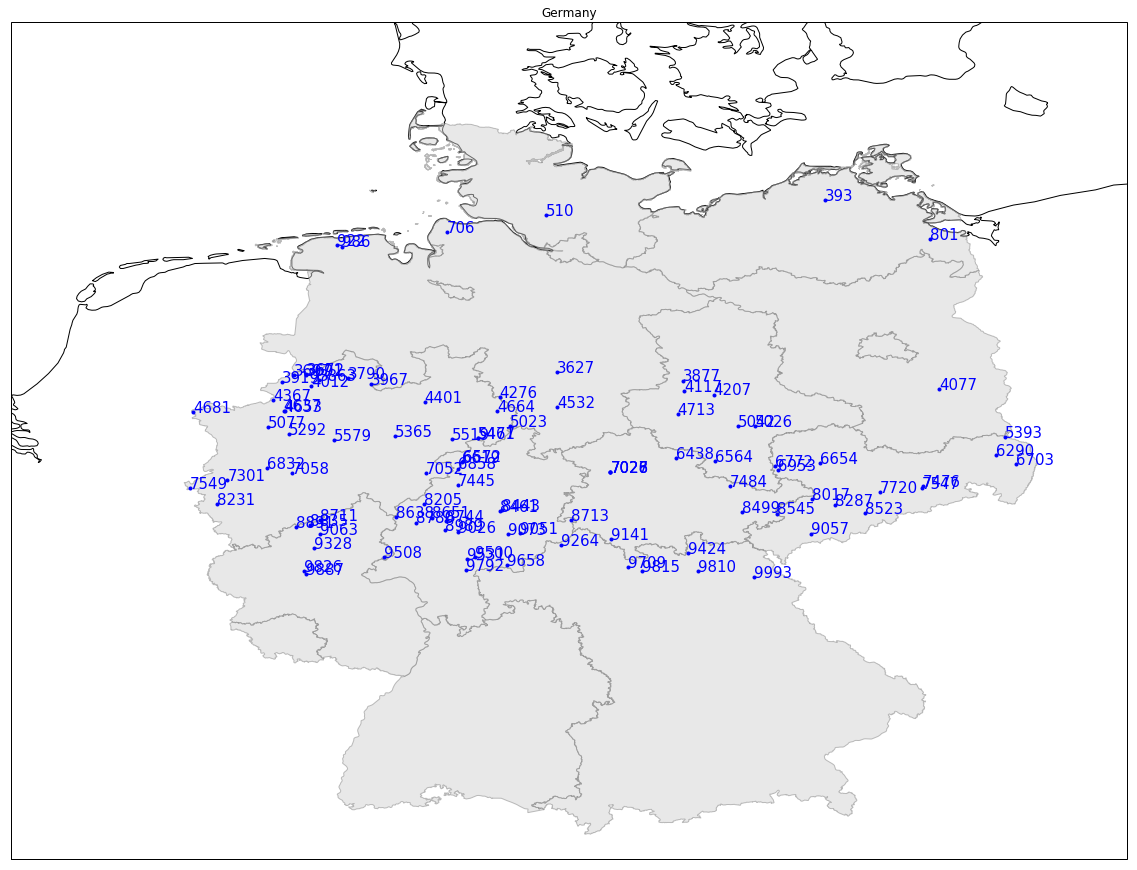

In [146]:
drawMap(possible_gas_stations)

## Plotting routes 

In [147]:
def plotingRoute(stations): 
    # Download map data from here http://biogeo.ucdavis.edu/data/gadm2.8/shp/DEU_adm_shp.zip
    # Read map data 
    fname = 'maps/DEU_adm1.shp'
    adm1_shapes = list(shpreader.Reader(fname).geometries())

    # Create figure 
    fig = plt.figure(figsize=(20, 30))
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.title('Germany')
    ax.coastlines(resolution='10m')

    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                      edgecolor='gray', facecolor='lightgray', alpha=0.5)

    ax.set_extent([4, 16, 47, 56], ccrs.PlateCarree())
    
    # Draw Gas Stations 
    first = True
    old_long, old_lat = 1, 1
    for index, row in stations.iterrows():
        if first:
            first = False
        else: 
            plt.plot([row["Longitude"], old_long],[row["Latitude"], old_lat],
                color='blue', linewidth=2, marker='o',
                transform=ccrs.Geodetic(),
                )
        ax.text(row["Longitude"], row["Latitude"], str(index), color="black", fontsize=15)
        old_lat, old_long = row["Latitude"], row["Longitude"]

    plt.show()

## Split up the data into routes 

In [148]:
def split_data(data, number_of_routes=10): 
    samples = []
    route_length = int(len(data)/number_of_routes)
    for i in range(number_of_routes):
        samples.append(data.sample(route_length, random_state = 10))
        data.drop(samples[i].index, inplace=True)
    return samples

def get_dist(a_lat, a_long, b_lat, b_long):
    #a_lat, a_long, b_lat, b_long = np.radians([a_lat, a_long, b_lat, b_long])
    return (6378.388 * acos((sin(a_lat) * sin(b_lat)) + ((cos(a_lat) * cos(b_lat)) * cos(b_long - a_long))))/100

def distance_between_stations(station_a, station_b): 
    return get_dist(station_a["Latitude"], station_a["Longitude"], station_b["Latitude"], station_b["Longitude"])

def find_close_gaststation(data, starting_station, number_of_stations): 
    route = pd.DataFrame()
    return route

def split_data_in_range(data, numer_of_routes = 10, number_of_stations = 20):
    samples
    for i in range(number_of_routes):
        print(i)
    return samples

In [149]:
samples = split_data(possible_gas_stations)

In [150]:
samples[2]

,Latitude,Longitude
9658,50.160905,9.332845
8713,50.649090,10.019980
393,54.093498,12.752200
9709,50.142426,10.638351
7027,51.163376,10.447683
4532,51.864861,9.873169
3967,52.105718,7.877718
9328,50.344920,7.259516
986,53.588430,7.565120
4637,51.825674,6.935979


## Plot all routes

In [151]:
def plot_all_routes(samples=samples): 
    for i in range(len(samples)):
        route = samples[i].sort_values(by=['Longitude', 'Latitude'])
        plotingRoute(route)

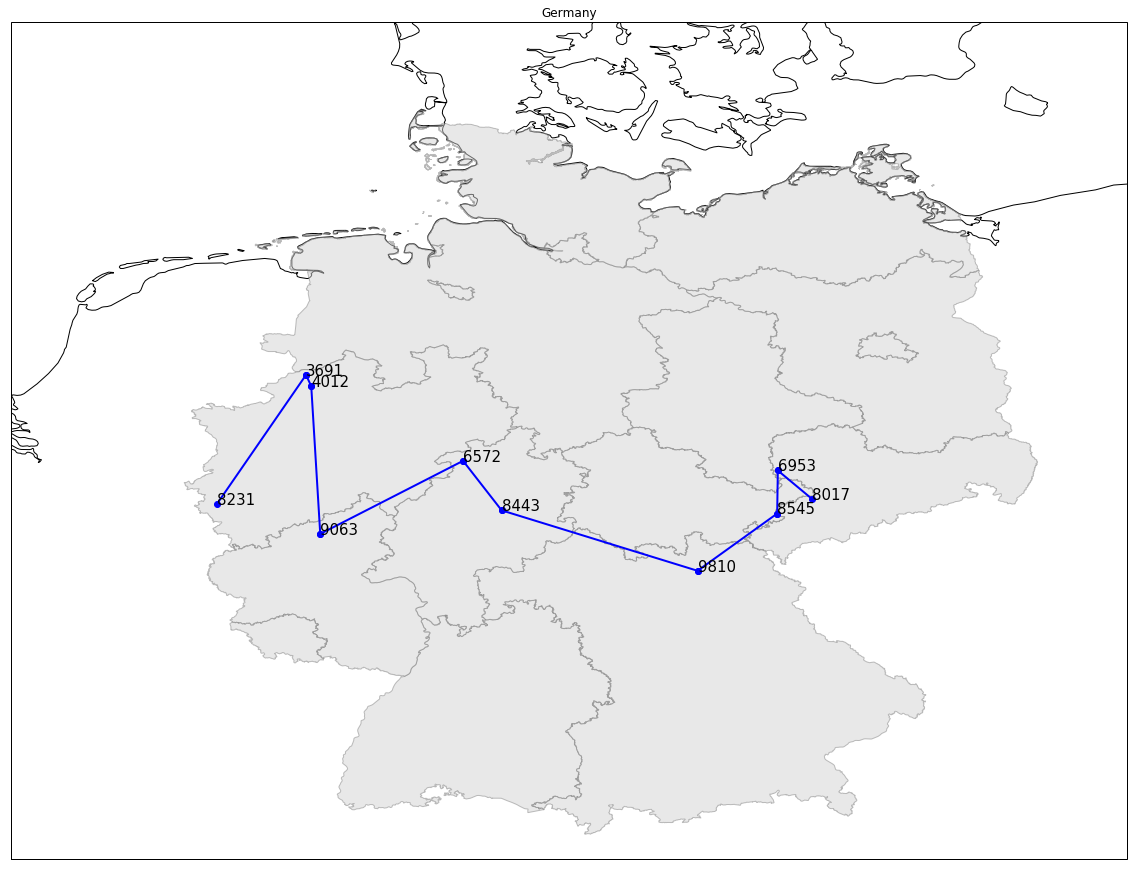

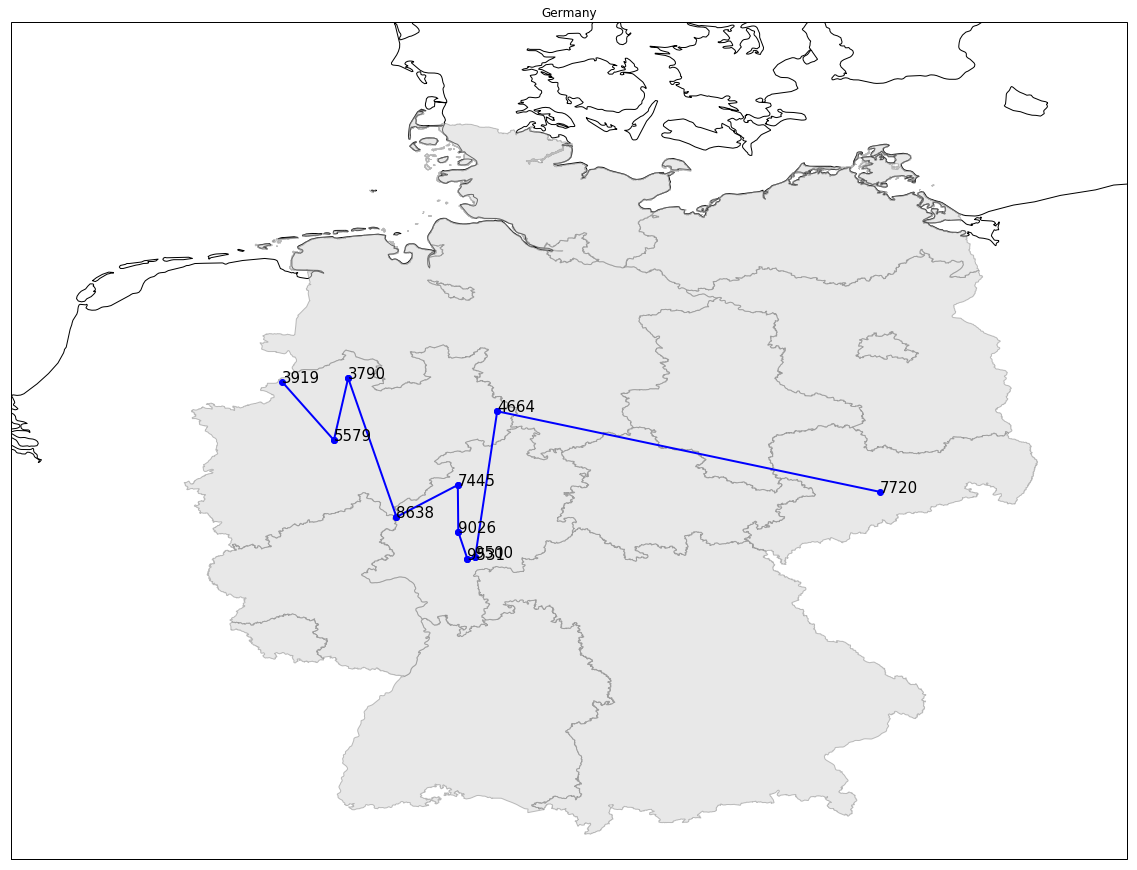

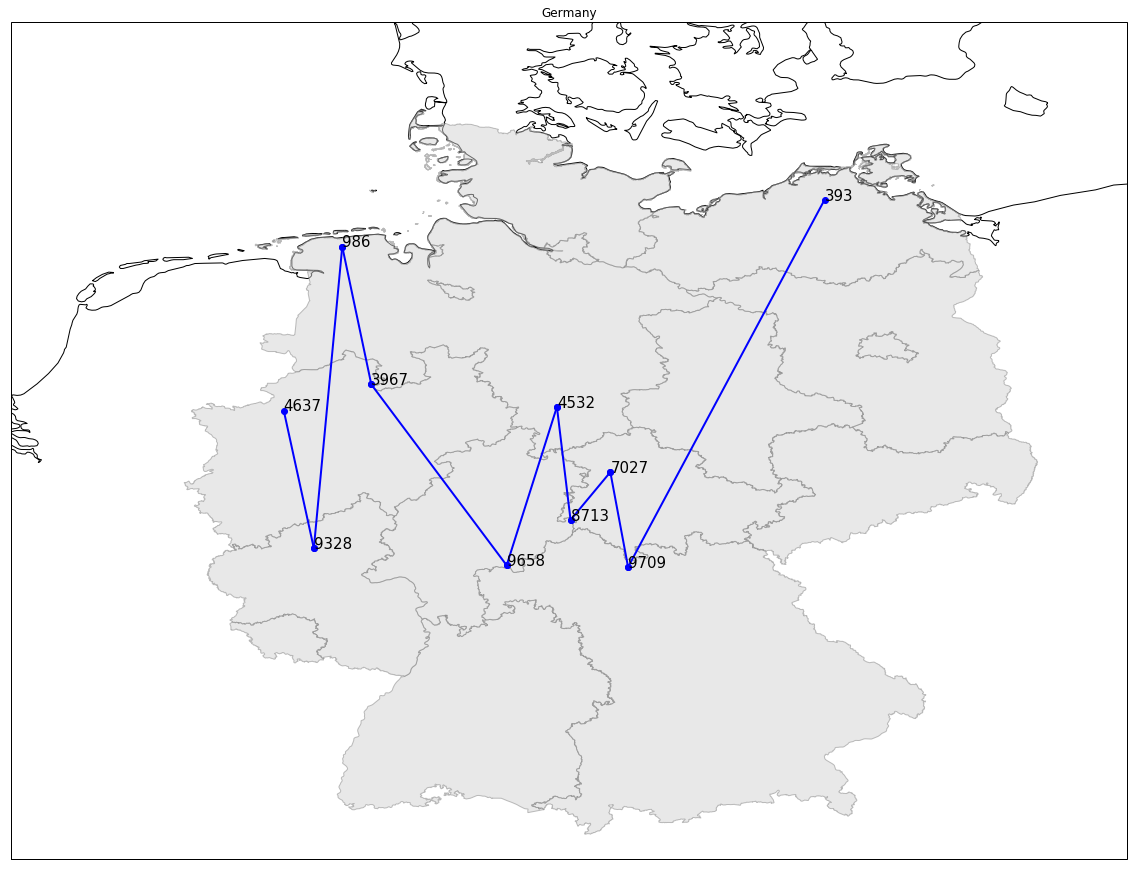

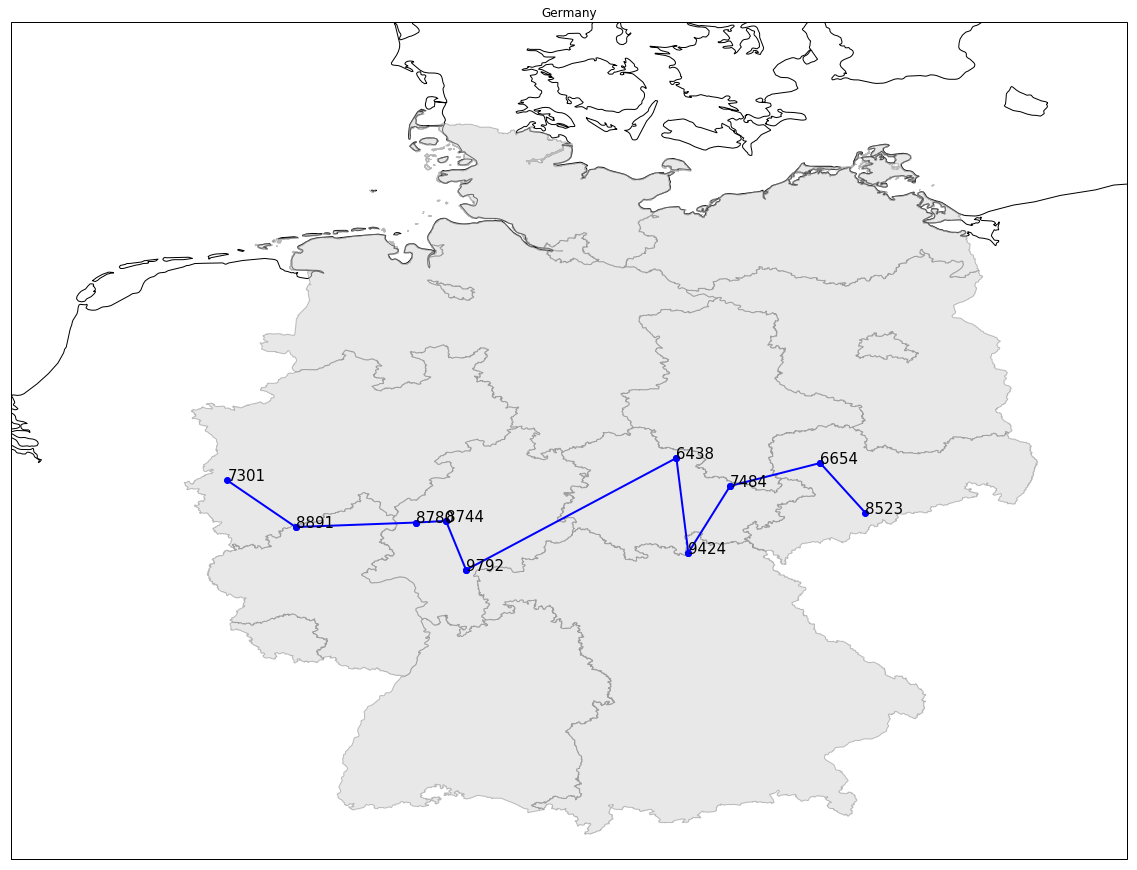

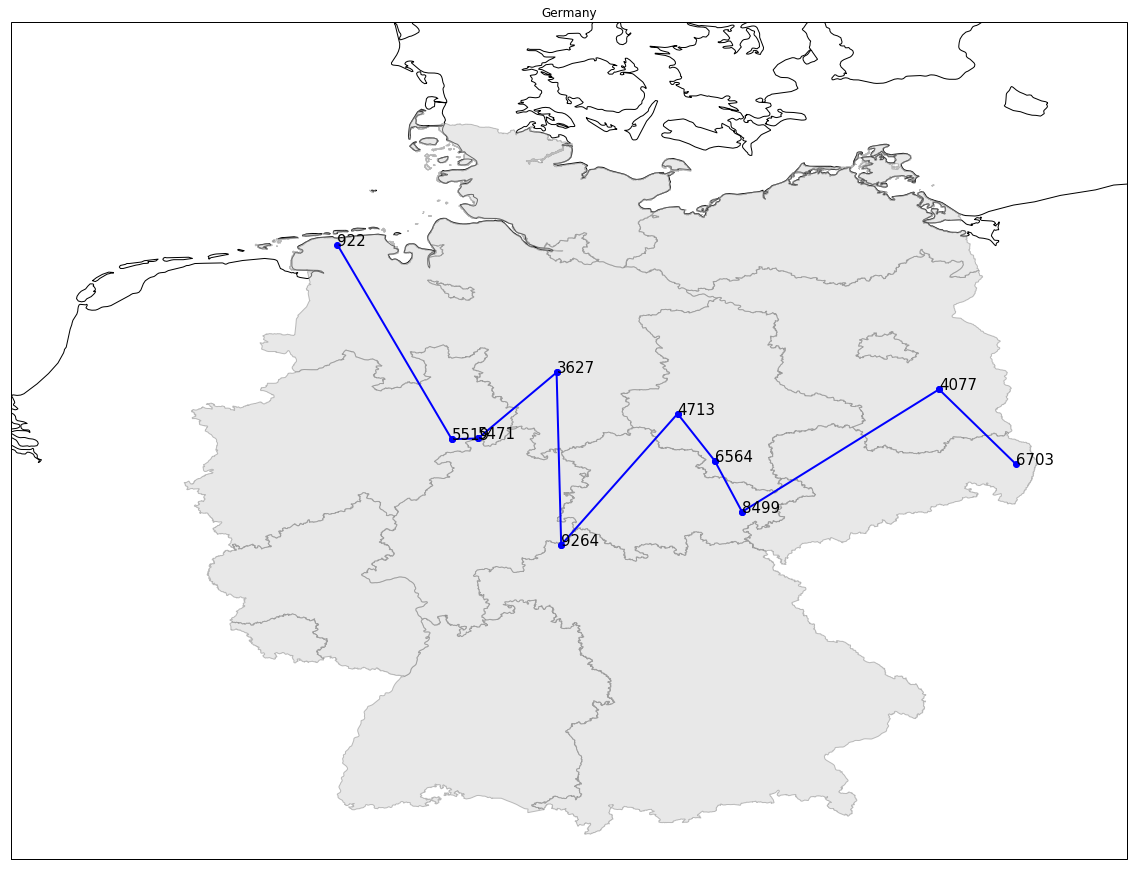

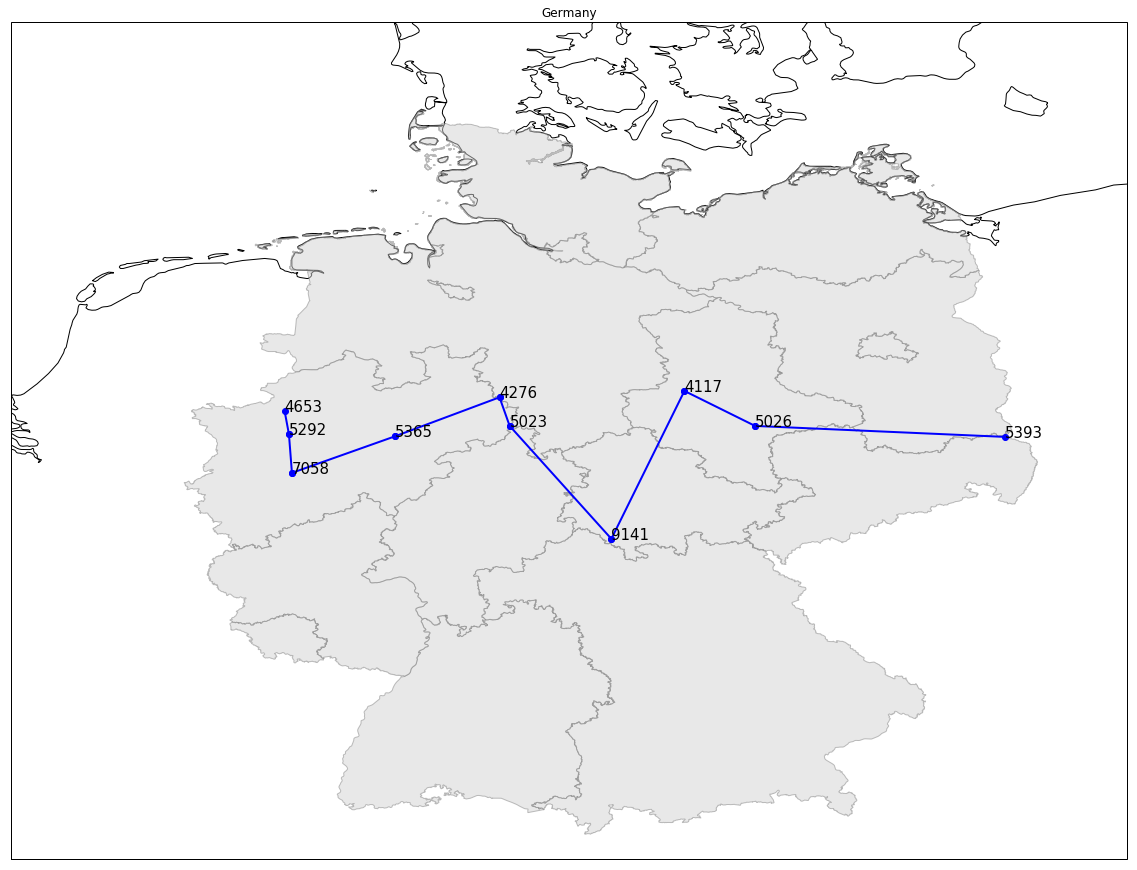

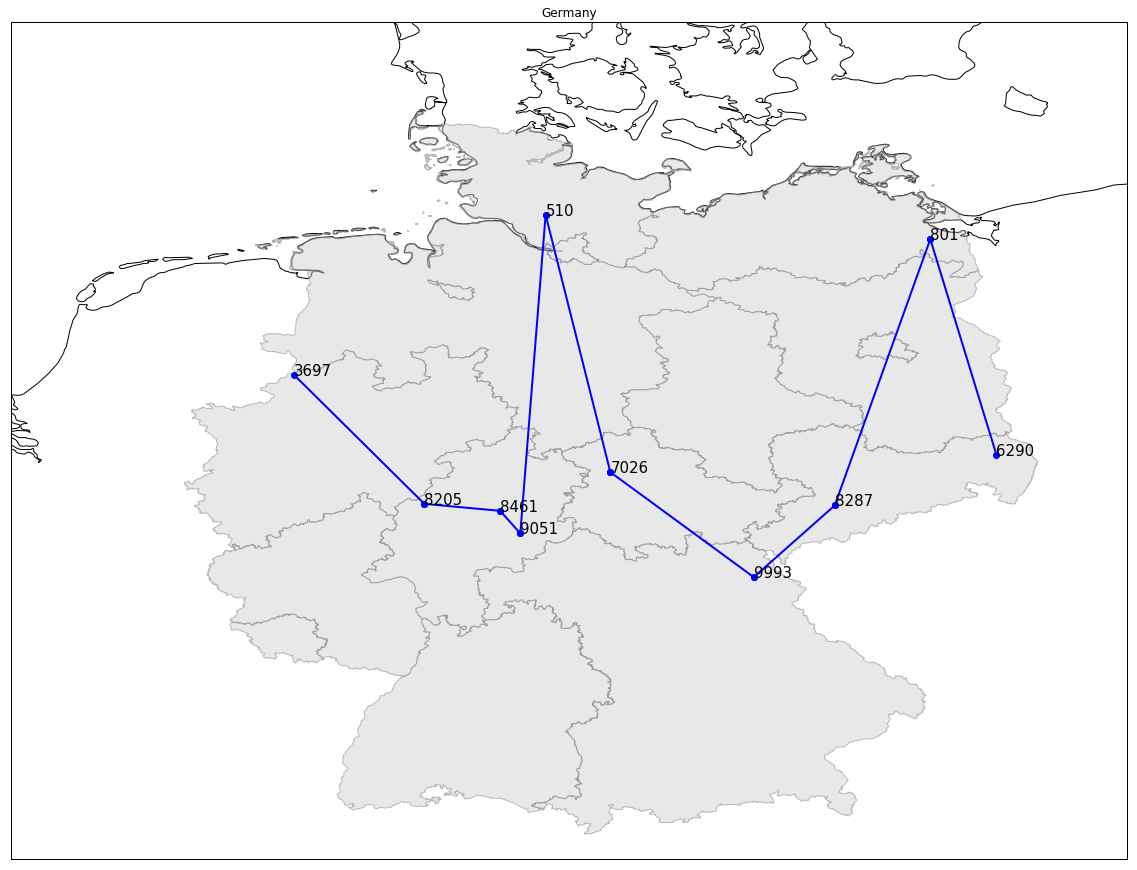

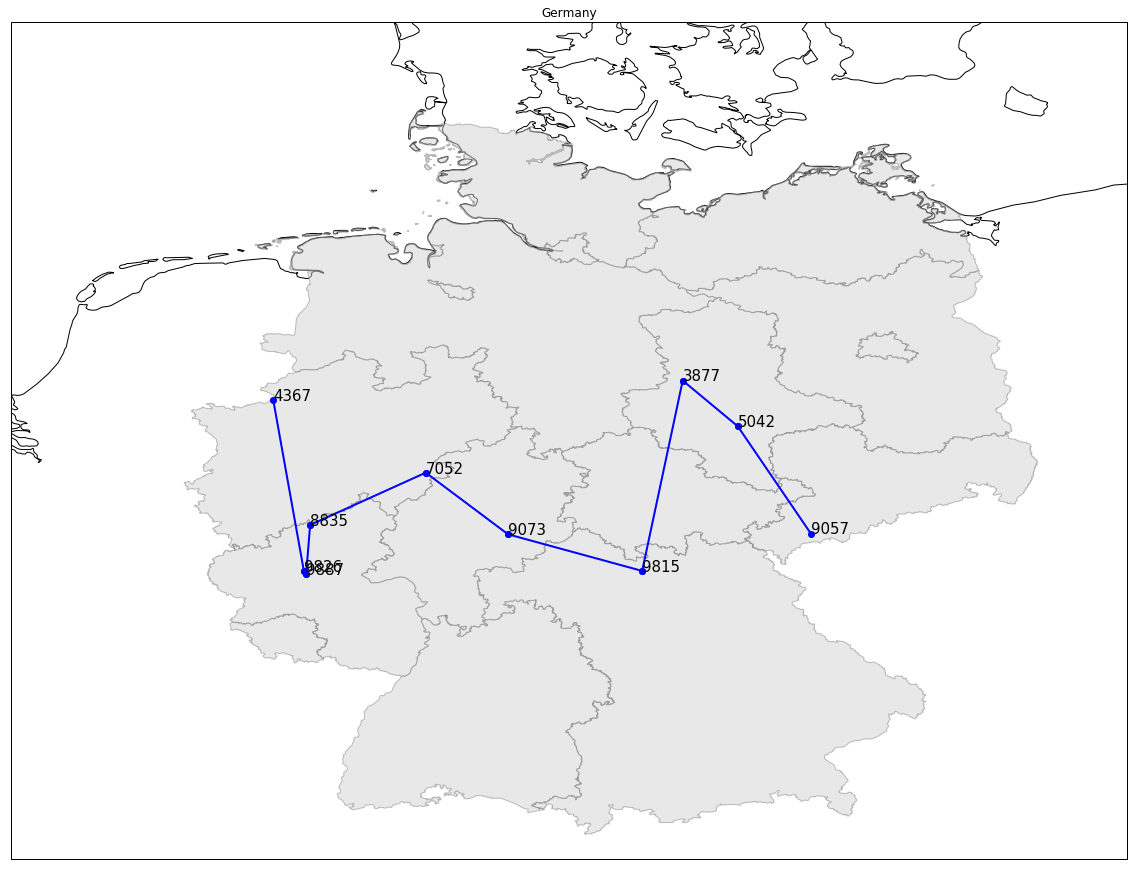

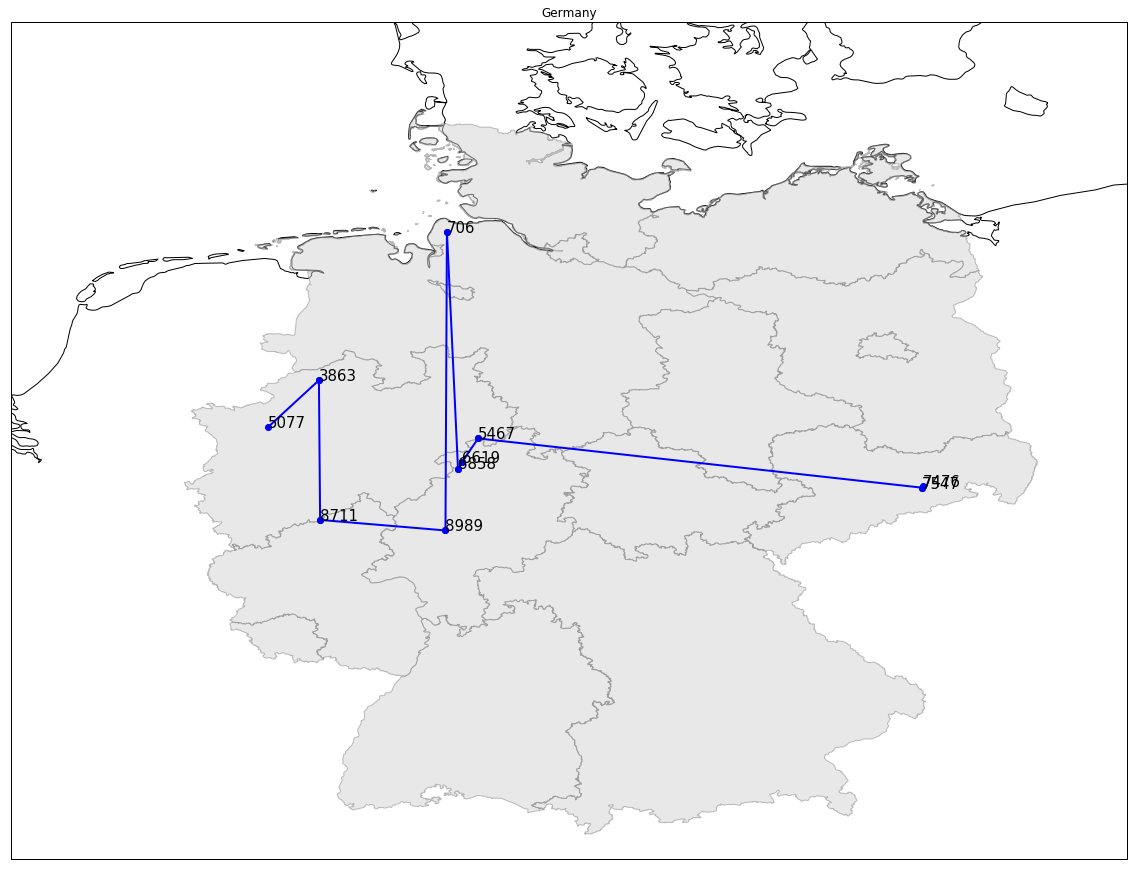

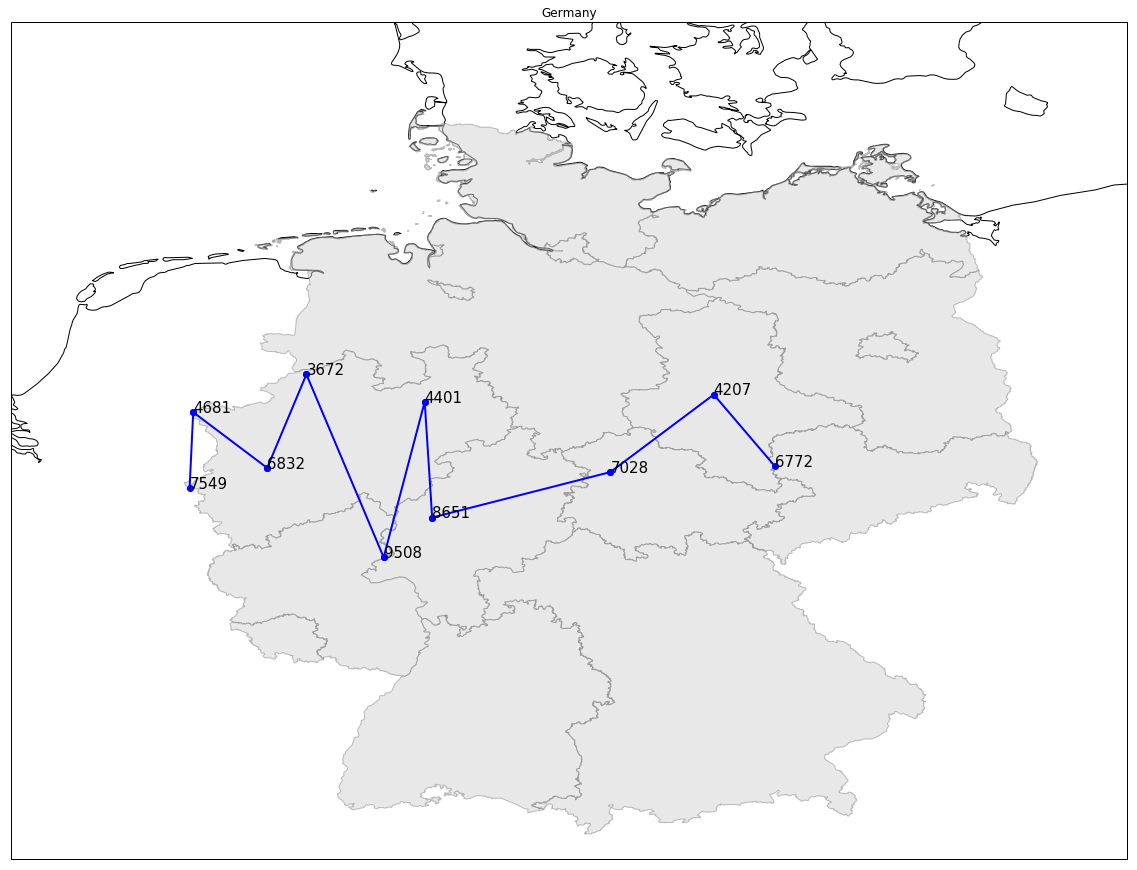

In [152]:
plot_all_routes(samples)

## Adding datetime to the stations, based on speed and location

In [153]:
def time_for_routes(starting_time, starting_fuel = 3, speed=50, route_samples=samples): 
    # inital variables
    old_long, old_lat, long, lat = 0, 0, 0, 0
    output_strings = []
    # For each route in list build output
    for sample_number in route_samples: 
        first = True
        current_time = starting_time
        route_times = str(starting_fuel) + "\n"
        for index, station in sample_number.iterrows():
            long = station[1]
            lat = station[0]
            if first:
                first = False
                route_times += str(current_time) + "; " + str(index) + "\n"
            else: 
                dist = get_dist(lat, long, old_lat, old_long)
                time_for_dist_in_hour = timedelta(hours = dist/50)
                current_time = current_time + time_for_dist_in_hour
                route_times += str(current_time).split(".")[0] + "; " + str(index) + "\n"
            old_long = long
            old_lat = lat
        output_strings.append(route_times)
    return output_strings

In [154]:
test = time_for_routes(datetime(2017, 9, 20, 12), route_samples=samples)

In [155]:
len(test)

10

In [156]:
test[9]

'3\n2017-09-20 12:00:00; 4401\n2017-09-20 12:41:44; 6772\n2017-09-20 13:43:18; 3672\n2017-09-20 14:13:03; 4681\n2017-09-20 14:27:07; 4207\n2017-09-20 15:41:34; 7549\n2017-09-20 18:11:37; 9508\n2017-09-20 20:50:58; 7028\n2017-09-20 22:26:14; 6832\n2017-09-21 00:09:59; 8651\n'

In [157]:
def write_to_file(input): 
    for route in input: 
        print(str(route))
        with open('workfile' + "_" + str(input.index(route)) + ".csv", "w") as f:
            f.write(str(route))

In [158]:
#write_to_file(test)

## Building the routes manually 

In [159]:
# Creating Routes maually 
# Because the index is most of the time close to the other stations with a similar index
# it is enough to limit the longitude and get resonable results 
# Although the routes are not sensable all the time 
possible_gas_stations = readGasStations(gas_station_mse[gas_station_mse.mse > 0].head(300).index.values)

myRoutes = []
myRoutes.append(possible_gas_stations.query('3000 < index < 4000 and Longitude < 12'))
myRoutes.append(possible_gas_stations.query('4000 < index < 5000 and Longitude < 9.5'))
myRoutes.append(possible_gas_stations.query('5000 < index < 5600 and Longitude < 9'))
myRoutes.append(possible_gas_stations.query('5600 < index < 7000 and Longitude < 12'))
myRoutes.append(possible_gas_stations.query('7000 < index < 8000 and Longitude < 12'))
myRoutes.append(possible_gas_stations.query('8000 < index < 9000 and Longitude < 10'))
myRoutes.append(possible_gas_stations.query('8000 < index < 9000 and Longitude > 10'))
myRoutes.append(samples[1])
myRoutes.append(samples[2])
myRoutes.append(samples[5])

In [160]:
final_routes = time_for_routes(datetime(2017, 9, 20, 12), starting_fuel=45, route_samples=myRoutes)

In [161]:
write_to_file(final_routes)

45
2017-09-20 12:00:00; 3790
2017-09-20 12:07:53; 3863
2017-09-20 12:20:36; 3967
2017-09-20 12:40:21; 3919
2017-09-20 12:46:56; 3697
2017-09-20 12:50:26; 3691
2017-09-20 13:47:52; 3627
2017-09-20 14:21:55; 3877
2017-09-20 15:09:13; 3672
2017-09-20 16:05:50; 3683
2017-09-20 16:56:44; 3858
2017-09-20 17:49:27; 3635
2017-09-20 18:43:46; 3853
2017-09-20 19:31:26; 3892
2017-09-20 20:14:30; 3721
2017-09-20 20:44:52; 3870

45
2017-09-20 12:00:00; 4653
2017-09-20 12:08:41; 4367
2017-09-20 12:15:11; 4664
2017-09-20 12:17:15; 4637
2017-09-20 12:26:47; 4276
2017-09-20 12:52:05; 4012
2017-09-20 13:12:07; 4681
2017-09-20 13:16:57; 4401
2017-09-20 13:25:12; 4683
2017-09-20 13:26:27; 4560
2017-09-20 13:38:26; 4250
2017-09-20 13:46:16; 4174
2017-09-20 14:00:52; 4544
2017-09-20 14:14:07; 4993
2017-09-20 14:34:21; 4081
2017-09-20 14:53:09; 4344
2017-09-20 15:02:02; 4737

45
2017-09-20 12:00:00; 5519
2017-09-20 12:13:52; 5365
2017-09-20 12:37:41; 5077
2017-09-20 12:54:36; 5579
2017-09-20 13:06:21; 5292
2

In [162]:
if 4638 in gas_station_mse[gas_station_mse.mse > 0].head(300).index.values: 
    print("True")

In [163]:
def readGasStations2(numbers):
    stations = pd.read_csv('../InformatiCup2018/Eingabedaten/Tankstellen.csv', sep=';', index_col=0,
                          names=["Name", "Provider", "Streetname", "Housenumber", "Zipcode", "City", "Latitude", "Longitude"])
    
    return stations.loc[numbers, ["Latitude", "Longitude"]]

if 4638 in readGasStations2(gas_station_mse[gas_station_mse.mse > 0].head(300).index.values).index.values: 
    print("True")